<a href="https://colab.research.google.com/github/AstorBoy11/Machine-Learning/blob/main/UTS_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS MACHINE LEARNING

Nama : Aril Ibbet Ardana Putra

Kelas : TI-3G

No : 6

NIM : 2341720095

In [13]:
# Import Librarires

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use('seaborn-v0_8')


## 1. Load dan Cek Dataset

Dataset Default of Credit Card Clients Dataset dimuat dan dilakukan pemeriksaan awal:
- Melihat jumlah baris dan kolom.
- Memeriksa tipe data tiap kolom.
- Menampilkan beberapa contoh data untuk memahami struktur dataset.

$$
\text{Tujuan: memastikan dataset terbaca dengan benar dan memahami struktur awal data.}
$$

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Machine Learning/heart_disease_uci.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


In [17]:
import numpy as np

# Cek nilai hilang (NaN)
missing = data.isna().sum()
print(missing[missing > 0] if not missing[missing > 0].empty else "Tidak ada nilai hilang (NaN).")

# Cek nilai tak hingga (inf / -inf)
num_cols = data.select_dtypes(include=[np.number]).columns  # hanya kolom numerik
inf_cols = num_cols[data[num_cols].apply(lambda x: np.isinf(x).any())]
print(f"Kolom dengan inf/-inf: {list(inf_cols)}" if len(inf_cols) > 0 else "Tidak ada nilai inf / -inf.")

# Cek nilai hilang (isnull)
missing_isnull = data.isnull().sum()
print(missing_isnull[missing_isnull > 0] if not missing_isnull[missing_isnull > 0].empty else "Tidak ada nilai hilang (isnull).")


trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Tidak ada nilai inf / -inf.
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64


## 2. Feature Engineering dan Data Preprocessing

Untuk tugas clustering (segmentasi), tujuannya adalah mengelompokkan pasien dengan karakteristik fisiologis yang serupa, bukan untuk melakukan prediksi terhadap kejadian penyakit secara langsung. Oleh karena itu, fitur dipilih berdasarkan kemampuannya dalam mendefinisikan profil kesehatan kardiovaskular dan kondisi medis pasien secara menyeluruh.

---

### Fitur yang Dipilih

Fitur-fitur dikelompokkan berdasarkan perannya dalam membentuk segmen pasien yang bermakna.

#### A. Grup Kondisi Fisiologis Utama
Fitur ini mendefinisikan kondisi fisik pasien yang secara langsung berhubungan dengan fungsi dan kesehatan jantung.

- **age**: Usia pasien, merupakan faktor risiko dominan terhadap kejadian penyakit jantung.  
- **trestbps**: Tekanan darah saat istirahat, menunjukkan tekanan kerja jantung dan kondisi sistem peredaran darah.  
- **chol**: Kadar kolesterol serum, indikator penting yang berhubungan dengan penyumbatan arteri dan risiko kardiovaskular.  
- **thalach**: Detak jantung maksimum yang dicapai, menggambarkan kapasitas kerja jantung selama aktivitas.  
- **oldpeak**: Depresi ST yang diinduksi oleh olahraga, menjadi indikator adanya gangguan aliran darah menuju otot jantung (iskemia).  

**Rujukan:**  
Reddy (2021) menunjukkan bahwa variabel fisiologis seperti **age**, **blood_pressure**, dan **cholesterol** merupakan faktor utama dalam pembentukan klaster pasien dengan kondisi medis yang serupa.  

*Kutipan Asli:*  
> “The model using K-Means Clustering found that age is the main factor in the prediction of the disease, as the centroids of the plots where age is considered show the greatest concentration and similarity.”  

**Sumber:**  
Reddy, G. D. (2021). *Heart Disease Clustering Using K-Mean Analysis.*  
*International Journal of Advance Research, Ideas and Innovations in Technology*, 7(4), 1381–1383.  
[https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf](https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf)

---

#### B. Grup Kombinasi Fitur (Feature Interaction)
Fitur dalam kelompok ini merupakan hasil penggabungan antar atribut fisiologis untuk menangkap hubungan kompleks yang dapat memengaruhi risiko penyakit jantung.

- **CholAge**: Hasil perkalian antara kolesterol dan usia pasien (*chol × age*), menggambarkan efek gabungan kadar lemak dalam darah dan proses penuaan terhadap risiko penyakit jantung.  
- **BP_Stress_Index**: Kombinasi antara tekanan darah istirahat dan depresi ST (*trestbps × oldpeak*), mengukur pengaruh tekanan darah terhadap tingkat stres jantung saat aktivitas.  

Fitur gabungan ini digunakan untuk memperkaya representasi data dan membantu algoritma clustering menemukan pola yang tidak terlihat secara eksplisit dari satu variabel tunggal.

**Rujukan:**  
Reddy (2021) menjelaskan bahwa interaksi antar variabel fisiologis seperti usia, tekanan darah, dan kolesterol membantu membedakan jenis-jenis kondisi jantung, seperti *typical angina*, *non-anginal pain*, dan *asymptomatic pain*.  

*Kutipan Asli:*  
> “The K-Means clustering helps us predict the happening of a chest pain in advance and is thus a very simple and popular clustering algorithm used in the industry.”  

**Sumber:**  
Reddy, G. D. (2021). *Heart Disease Clustering Using K-Mean Analysis.*  
*International Journal of Advance Research, Ideas and Innovations in Technology*, 7(4), 1381–1383.  
[https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf](https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf)

---

#### C. Grup Profil Demografis
Fitur ini memberikan konteks tambahan terhadap interpretasi klaster yang terbentuk, sehingga dapat membantu dalam memahami distribusi risiko berdasarkan karakteristik individu.

- **sex**: Jenis kelamin pasien, karena prevalensi penyakit jantung dapat berbeda antara laki-laki dan perempuan.  
- **cp**: Jenis nyeri dada yang dialami pasien, mencerminkan tipe kondisi jantung yang diderita (misalnya *typical angina*, *non-anginal pain*, atau *asymptomatic*).  

**Rujukan:**  
Menurut Reddy (2021), atribut demografis dan simptomatik seperti **sex** dan **chest pain type** tetap penting untuk mendukung interpretasi hasil clustering karena membantu mengidentifikasi kelompok pasien dengan karakteristik gejala yang berbeda.  

*Kutipan Asli:*  
> “We have clustered the data and found out that there are three types of heart diseases namely typical angina pain, non-anginal pain, asymptomatic pain.”  

**Sumber:**  
Reddy, G. D. (2021). *Heart Disease Clustering Using K-Mean Analysis.*  
*International Journal of Advance Research, Ideas and Innovations in Technology*, 7(4), 1381–1383.  
[https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf](https://www.ijariit.com/manuscripts/v7i4/V7I4-1730.pdf)


In [21]:

num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].mean())

cat_cols = data.select_dtypes(exclude=['float64', 'int64']).columns
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

data['CholAge'] = data['chol'] * data['age']
data['BP_Stress_Index'] = data['trestbps'] * data['oldpeak']

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

print("Feature engineering dan normalisasi selesai!")
display(data.head())

Feature engineering dan normalisasi selesai!


id       age     sex    dataset               cp  trestbps      chol  \
0 -1.730169  1.007386    Male  Cleveland   typical angina  0.698041  0.311021   
1 -1.726404  1.432034    Male  Cleveland     asymptomatic  1.511761  0.797713   
2 -1.722639  1.432034    Male  Cleveland     asymptomatic -0.658158  0.274289   
3 -1.718873 -1.752828    Male  Cleveland      non-anginal -0.115679  0.467130   
4 -1.715108 -1.328180  Female  Cleveland  atypical angina -0.115679  0.044717   

     fbs         restecg    thalch  exang   oldpeak        slope        ca  \
0   True  lv hypertrophy  0.495698  False  1.349421  downsloping -1.249371   
1  False  lv hypertrophy -1.175955   True  0.589832         flat  4.292099   
2  False  lv hypertrophy -0.340128   True  1.634267         flat  2.444942   
3  False          normal  1.968345  False  2.488805  downsloping -1.249371   
4  False  lv hypertrophy  1.371326  False  0.494884    upsloping -1.249371   

                thal       num  CholAge  BP_Stress_Index  
0       fixed defect -0.871794  14679.0            333.5  
1             normal  0.879408  19162.0            240.0  
2  reversable defect  0.003807  15343.0            312.0  
3             normal -0.871794   9250.0            455.0  
4             normal -0.871794   8364.0            182.0

In [22]:
# save Dataset
output_path = "heart_disease_uci.csv"
data.to_csv(output_path, index=False)

print(f"\nDataset berhasil disimpan ke: {output_path}")



Dataset berhasil disimpan ke: heart_disease_uci.csv


## 3. Analisis Distribusi Data Numerik

Pada tahap ini dilakukan visualisasi sebaran data dari tiap kolom untuk menentukan metode scaling apa yang cocok untuk digunakan
    
---

=== CEK SEBARAN DISTRIBUSI DATA NUMERIK (10 KOLOM) ===


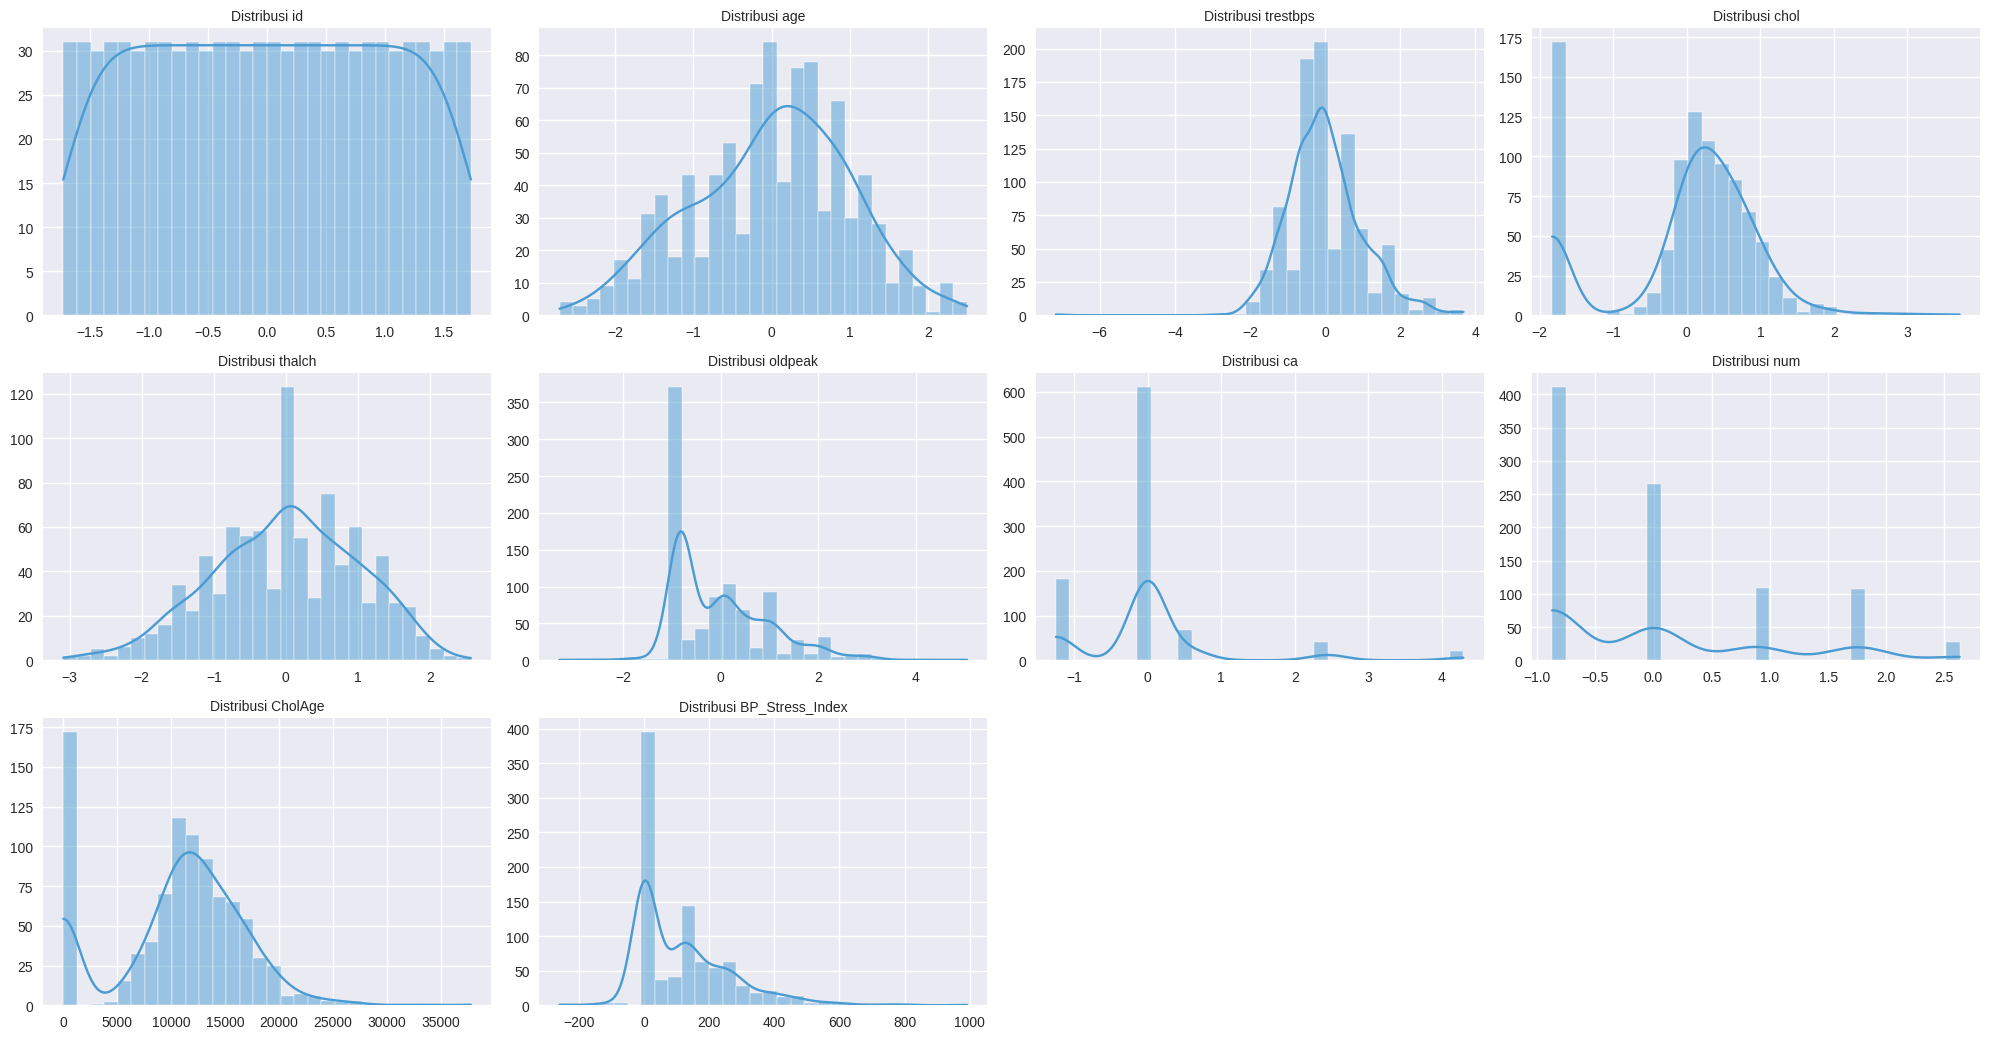

In [23]:
# === GANTI NILAI inf / -inf DENGAN NaN ===
data_cluster = data.replace([np.inf, -np.inf], np.nan)

# === PILIH HANYA KOLOM NUMERIK ===
num_cols = data_cluster.select_dtypes(include=['int64', 'float64']).columns

print(f"=== CEK SEBARAN DISTRIBUSI DATA NUMERIK ({len(num_cols)} KOLOM) ===")

# === PLOT DISTRIBUSI HISTOGRAM UNTUK SEMUA KOLOM NUMERIK ===
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(5 * n_cols, 3.5 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data_cluster[col].dropna(), kde=True, bins=30, color="#4B9CD3", edgecolor="white")
    plt.title(f'Distribusi {col}', fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

# Physiological and Demographic-Based Patient Segmentation on Heart Disease Dataset Using K-Means and DBSCAN Clustering (Integrating Cardiovascular Attributes and Demographic Factors for Enhanced Risk Profiling)

In [24]:
cuy = pd.read_csv('/content/heart_disease_uci.csv')
cuy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               920 non-null    float64
 1   age              920 non-null    float64
 2   sex              920 non-null    object 
 3   dataset          920 non-null    object 
 4   cp               920 non-null    object 
 5   trestbps         920 non-null    float64
 6   chol             920 non-null    float64
 7   fbs              920 non-null    bool   
 8   restecg          920 non-null    object 
 9   thalch           920 non-null    float64
 10  exang            920 non-null    bool   
 11  oldpeak          920 non-null    float64
 12  slope            920 non-null    object 
 13  ca               920 non-null    float64
 14  thal             920 non-null    object 
 15  num              920 non-null    float64
 16  CholAge          920 non-null    float64
 17  BP_Stress_Index 

In [25]:
# === DAFTAR FITUR TERPILIH ===
selected_features = [
    # Fitur Asli Penting
    "age",              # Usia pasien
    "sex",              # Jenis kelamin
    "cp",               # Tipe nyeri dada
    "trestbps",         # Tekanan darah saat istirahat
    "chol",             # Kolesterol serum
    "thalach",          # Detak jantung maksimum
    "oldpeak",          # Depresi ST yang diinduksi oleh olahraga

    # Fitur Hasil Feature Engineering
    "CholAge",          # Kolesterol × usia
    "BP_Stress_Index"   # Tekanan darah × depresi ST
]

# === FILTER DATA SESUAI FITUR TERSEDIA ===
data_cluster = data[[col for col in selected_features if col in data.columns]].copy()

# === CEK NILAI INVALID (NaN/Inf) SEBELUM TRANSFORMASI ===
print("\n=== Check for Invalid Values (Sebelum Transformasi) ===")
for col in data_cluster.select_dtypes(include=[np.number]).columns:
    nan_count = data_cluster[col].isna().sum()
    inf_count = np.isinf(data_cluster[col].values).sum()
    print(f"{col} - NaN: {nan_count} | Inf: {inf_count}")



=== Check for Invalid Values (Sebelum Transformasi) ===
age - NaN: 0 | Inf: 0
trestbps - NaN: 0 | Inf: 0
chol - NaN: 0 | Inf: 0
oldpeak - NaN: 0 | Inf: 0
CholAge - NaN: 0 | Inf: 0
BP_Stress_Index - NaN: 0 | Inf: 0


## 4. Scaling pada Dataset

Pada tahap ini, untuk memperbaiki distribusi data numerik yang memiliki *skew* tinggi atau varians besar, serta agar algoritma berbasis jarak seperti **K-Means** dan **DBSCAN** bekerja lebih optimal, diterapkan **Yeo–Johnson Power Transformation** untuk menormalkan distribusi fitur numerik.  
Setelah itu, digunakan **StandardScaler** agar semua fitur memiliki skala yang sebanding (mean = 0, standar deviasi = 1), sehingga tidak ada fitur yang mendominasi proses perhitungan jarak antar data.

### Referensi
[Yeo, I.-K., & Johnson, R. A. (2000). *A new family of power transformations to improve normality or symmetry*. Biometrika, 87(4), 954–959.](https://doi.org/10.1093/biomet/87.4.954)


In [27]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

# Salin data untuk transformasi
data_cluster_original = data_cluster.copy()
data_cluster_processed = data_cluster.copy()

# Ubah kolom non-numerik menjadi numerik (label encoding)
for col in data_cluster_processed.columns:
    if data_cluster_processed[col].dtype == 'object':
        le = LabelEncoder()
        data_cluster_processed[col] = le.fit_transform(data_cluster_processed[col])

# === POWER TRANSFORMER (YEO-JOHNSON) ===
pt = PowerTransformer(method='yeo-johnson', standardize=False)
data_cluster_processed = pd.DataFrame(
    pt.fit_transform(data_cluster_processed),
    columns=data_cluster.columns,
    index=data_cluster.index
)

# === STANDARD SCALER ===
scaler = StandardScaler()
data_cluster_processed = pd.DataFrame(
    scaler.fit_transform(data_cluster_processed),
    columns=data_cluster.columns,
    index=data_cluster.index
)

# === OUTPUT ===
print("\n=== Preprocessing Selesai ===")
print(f"Shape akhir: {data_cluster_processed.shape}")
print(f"Total missing values: {data_cluster_processed.isna().sum().sum()}")

print("\n=== Statistik Kolom Setelah Transformasi ===")
display(data_cluster_processed.describe().T[['min', 'max', 'mean', 'std']])

# Update variabel utama untuk clustering
data_cluster = data_cluster_processed.copy()



=== Preprocessing Selesai ===
Shape akhir: (920, 8)
Total missing values: 0

=== Statistik Kolom Setelah Transformasi ===


min       max          mean       std
age             -2.484032  2.734051  0.000000e+00  1.000544
sex             -1.934494  0.516931  1.544658e-16  1.000544
cp              -0.903565  1.541516 -1.544658e-17  1.000544
trestbps        -8.590596  3.317908  1.544658e-17  1.000544
chol            -1.625178  5.681275 -6.178632e-17  1.000544
oldpeak         -6.395929  2.965896 -1.544658e-17  1.000544
CholAge         -1.976192  2.107579 -3.398248e-16  1.000544
BP_Stress_Index -8.059603  4.436340  1.467425e-16  1.000544

## 5. Elbow Method

Setelah *scaling* dan *encoding*, untuk menentukan jumlah kluster optimal pada metode **K-Means**, digunakan **Elbow Method**.  
Metode ini mengevaluasi nilai *inertia* dari berbagai jumlah kluster  K  K , lalu memilih titik di mana penurunan *inertia* mulai melambat (titik siku grafik).

$$
\text{Inertia}(K) =
\sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Titik “siku” (*elbow point*) pada grafik menunjukkan jumlah kluster yang optimal, karena setelah titik tersebut peningkatan jumlah kluster tidak memberikan perbaikan signifikan pada hasil klastering.

---

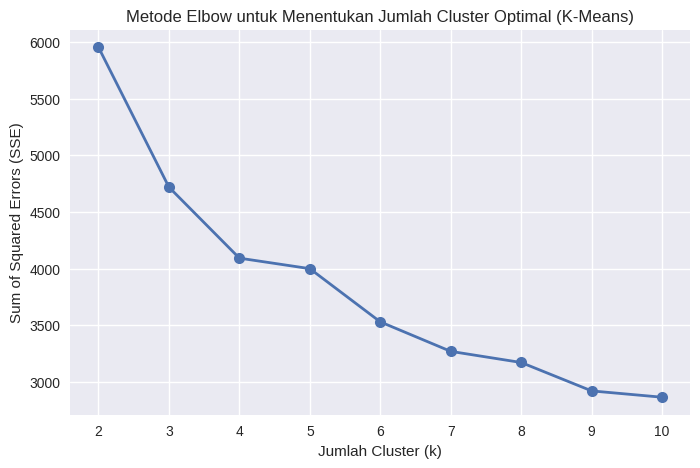


=== Nilai SSE Tiap K ===
k = 2: SSE = 5955.60
k = 3: SSE = 4719.64
k = 4: SSE = 4092.13
k = 5: SSE = 3999.23
k = 6: SSE = 3529.13
k = 7: SSE = 3268.49
k = 8: SSE = 3170.10
k = 9: SSE = 2919.14
k = 10: SSE = 2863.32


In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === DEFINISIKAN FITUR UNTUK CLUSTERING ===
X = data_cluster.values  # semua kolom numerik hasil transformasi

# === METODE ELBOW ===
sse = []
K = range(2, 11)  # range jumlah cluster yang diuji

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# === VISUALISASI ELBOW ===
plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'o-', linewidth=2, markersize=8)
plt.title("Metode Elbow untuk Menentukan Jumlah Cluster Optimal (K-Means)")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.show()

# === CETAK NILAI SSE ===
print("\n=== Nilai SSE Tiap K ===")
for k, val in zip(K, sse):
    print(f"k = {k}: SSE = {val:.2f}")

## 6. Clustering dengan K-Means

Setelah jumlah kluster optimal diperoleh dari *Elbow Method*, proses klasterisasi dilakukan menggunakan algoritma **K-Means**.  
Algoritma ini bekerja dengan membagi data ke dalam  K  K  kelompok (kluster) berdasarkan jarak terdekat ke titik pusat (centroid).

Tujuan utama K-Means adalah meminimalkan jumlah kuadrat jarak antar titik data ke centroid klusternya masing-masing.

---

## 7. Visualisasi PCA 2D

Untuk mempermudah interpretasi hasil klasterisasi, digunakan teknik **PCA (Principal Component Analysis)** guna mereduksi dimensi data menjadi 2 atau 3 komponen utama tanpa kehilangan terlalu banyak informasi.

### a. Visualisasi 2D
Dua komponen utama pertama ( PC_1  PC_1  dan  PC_2  PC_2 ) digunakan untuk memetakan setiap pengguna Netflix ke dalam bidang dua dimensi.  
Warna titik menunjukkan kluster hasil K-Means.

---


K-Means (K=5)
Silhouette Score: 0.2267
Davies-Bouldin Index: 1.4329


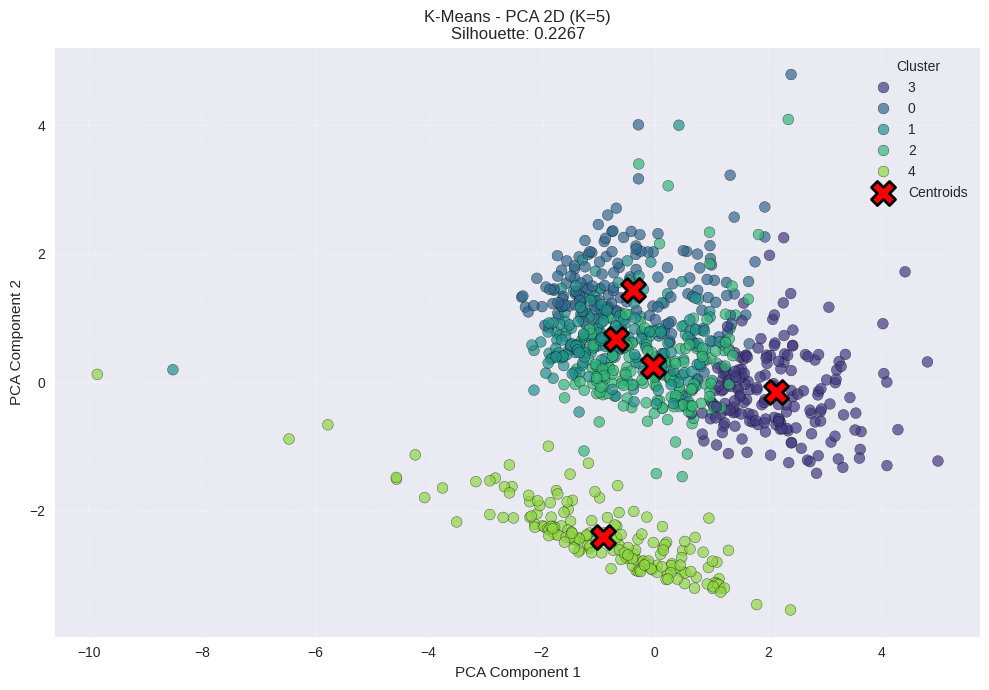

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========================================
# K-MEANS CLUSTERING
# ========================================
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
labels = kmeans.fit_predict(X)

# Evaluation Metrics
silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
print(f"\nK-Means (K={optimal_k})")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

# ========================================
# PCA REDUCTION
# ========================================
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X.values if isinstance(X, pd.DataFrame) else X)

centroids_2d = pca_2d.transform(kmeans.cluster_centers_)

df_viz = pd.DataFrame({
    'pca1': X_pca_2d[:, 0],
    'pca2': X_pca_2d[:, 1],
    'cluster': labels.astype(str)
})

# ========================================
# PCA 2D PLOT
# ========================================
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_viz,
    x='pca1', y='pca2',
    hue='cluster',
    palette='viridis',
    s=60, alpha=0.7,
    edgecolor='k', linewidth=0.3
)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', s=300, marker='X',
            edgecolors='black', linewidth=2,
            label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-Means - PCA 2D (K={optimal_k})\nSilhouette: {silhouette:.4f}')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### c. Analisis Kontribusi Komponen PCA
Kontribusi atau *explained variance ratio* menunjukkan seberapa besar proporsi variansi data yang dijelaskan oleh masing-masing komponen utama.

Nilai ini membantu menjelaskan seberapa besar informasi yang masih dipertahankan setelah reduksi dimensi.

---

In [30]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

X = data_cluster.copy()

# PCA 2D
pca_2d = PCA(n_components=2, random_state=42)
pca_result = pca_2d.fit_transform(X)

print("\n" + "="*50)
print("INTERPRETASI PCA 2D")
print("="*50)

# Variance explained
print("\nVariance Explained:")
print(f"PCA 1: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"PCA 2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"Total: {pca_2d.explained_variance_ratio_.sum():.2%}")

# Kontribusi fitur (loading matrix)
print("\nKontribusi Fitur pada Komponen PCA 2D:")
print("-" * 50)

feature_names = X.columns
loadings_2d = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PCA 1', 'PCA 2'],
    index=feature_names
)

loadings_2d['PCA1_abs'] = loadings_2d['PCA 1'].abs()
loadings_2d['PCA2_abs'] = loadings_2d['PCA 2'].abs()

print("\nTop 5 fitur untuk PCA 1:")
display(loadings_2d.nlargest(5, 'PCA1_abs')[['PCA 1']])

print("\nTop 5 fitur untuk PCA 2:")
display(loadings_2d.nlargest(5, 'PCA2_abs')[['PCA 2']])

pca_loadings = loadings_2d.sort_values(by='PCA1_abs', ascending=False)


INTERPRETASI PCA 2D

Variance Explained:
PCA 1: 29.59%
PCA 2: 24.62%
Total: 54.21%

Kontribusi Fitur pada Komponen PCA 2D:
--------------------------------------------------

Top 5 fitur untuk PCA 1:


PCA 1
BP_Stress_Index  0.587669
oldpeak          0.569517
age              0.282405
trestbps         0.276457
CholAge          0.275821


Top 5 fitur untuk PCA 2:


PCA 2
chol     0.614476
CholAge  0.601650
sex     -0.317254
cp       0.263648
oldpeak -0.200469

## 8. Interpretasi dan Ringkasan Klaster

Setelah proses klasterisasi selesai, hasilnya digabungkan kembali dengan data asli (sebelum pelabelan).  
Tahap ini bertujuan untuk memahami karakteristik tiap klaster pasien dalam dataset penyakit jantung, sehingga dapat memberikan gambaran tentang kelompok individu dengan profil kesehatan serupa.

### a. Explain Point dengan Visualisasi PCA 3D (Plotly)

Fungsi *Explain Point* digunakan untuk menjelaskan karakteristik satu pasien berdasarkan fitur-fitur fisiologis dan demografis dominan di klaster tempat ia tergabung.  
Visualisasi menggunakan **PCA 3D (Plotly)** memudahkan analisis distribusi antar-klaster sekaligus memungkinkan eksplorasi interaktif terhadap data.

Contoh interpretasi:
> “Pasien ini tergabung dalam Cluster 1 — berusia di atas 55 tahun, memiliki tekanan darah tinggi, kadar kolesterol di atas rata-rata, dan nilai *oldpeak* tinggi yang menunjukkan indikasi iskemia.”

---

Untuk menggunakan fungsi `explain_point()`, cukup arahkan kursor (*hover*) pada titik yang ingin dijelaskan pada plot PCA 3D, kemudian panggil fungsi dengan cara berikut:

```python
explain_point(42)


In [31]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# ========================================
# PERSIAPAN DATA
# ========================================
# X = data yang sudah di-transform (dari kode sebelumnya: data_cluster.values)
# data_cluster_original = data asli sebelum transformasi

# Jika X sudah didefinisikan sebagai numpy array, gunakan data_cluster untuk feature names
if isinstance(X, np.ndarray):
    feature_names = data_cluster.columns.tolist()
else:
    X = data_cluster.copy()
    feature_names = X.columns.tolist()

# ========================================
# Perhitungan PCA 3D (PCA REDUCTION)
# ========================================
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X.values if isinstance(X, pd.DataFrame) else X)

# Transform centroids ke ruang PCA
centroids_3d = pca_3d.transform(kmeans.cluster_centers_)

# DataFrame untuk visualisasi
df_viz = pd.DataFrame({
    'pca3_comp1': X_pca_3d[:, 0],
    'pca3_comp2': X_pca_3d[:, 1],
    'pca3_comp3': X_pca_3d[:, 2],
    'cluster': labels.astype(str)
})

# ========================================
# PERSIAPAN DATA DENGAN ORIGINAL VALUES
# ========================================
# Gunakan data SEBELUM encoding untuk interpretasi
df_analysis = data_cluster_original.copy()  # Data asli sebelum preprocessing
df_analysis['cluster'] = labels
df_analysis['pca1'] = X_pca_3d[:, 0]
df_analysis['pca2'] = X_pca_3d[:, 1]
df_analysis['pca3'] = X_pca_3d[:, 2]
df_analysis['point_id'] = range(len(df_analysis))

print(f"Data siap - Total: {len(df_analysis)} points, Cluster: {df_analysis['cluster'].nunique()}")

# ========================================
# INTERPRETASI PCA 3D
# ========================================
print("\n" + "="*50)
print("INTERPRETASI PCA 3D")
print("="*50)

# Variance explained
print(f"\nVariance Explained:")
for i in range(3):
    print(f"  PCA {i+1}: {pca_3d.explained_variance_ratio_[i]:.2%}")
print(f"  Total: {pca_3d.explained_variance_ratio_.sum():.2%}")

# Loading matrix untuk 3D
print(f"\nKontribusi Fitur pada Komponen PCA 3D:")
print("-" * 50)

loadings_3d = pd.DataFrame(
    pca_3d.components_.T,
    columns=['PCA 1', 'PCA 2', 'PCA 3'],
    index=feature_names
)

for i, col in enumerate(['PCA 1', 'PCA 2', 'PCA 3'], 1):
    loadings_3d[f'{col}_abs'] = loadings_3d[col].abs()
    print(f"\nTop 5 fitur untuk {col}:")
    print(loadings_3d.nlargest(5, f'{col}_abs')[[col]])

# ========================================
# FUNGSI EXPLAIN POINT
# ========================================
def explain_point(point_index):
    """Menjelaskan karakteristik user tertentu dengan data ORIGINAL"""
    if point_index >= len(df_analysis) or point_index < 0:
        print("Index tidak valid!")
        return

    row = df_analysis.iloc[point_index]
    cluster_id = int(row['cluster'])

    print("="*70)
    print(f"{'USER #' + str(point_index) + ' - CLUSTER ' + str(cluster_id):^70}")
    print("="*70)
    print(f"Posisi PCA 3D: ({row['pca1']:.3f}, {row['pca2']:.3f}, {row['pca3']:.3f})")

    # Karakteristik User (DATA ORIGINAL)
    print("\nKARAKTERISTIK:")
    print("-"*70)
    exclude = ['pca1', 'pca2', 'pca3', 'point_id', 'cluster']

    for col in df_analysis.columns:
        if col not in exclude:
            value = row[col]
            if pd.notna(value):
                if isinstance(value, (int, np.integer)):
                    print(f"  • {col:.<30} : {value}")
                elif isinstance(value, (float, np.floating)):
                    print(f"  • {col:.<30} : {value:.2f}")
                else:
                    # Tampilkan nilai kategorikal ASLI (genre_primary: "Action" bukan "9")
                    print(f"  • {col:.<30} : {value}")

    # Info Cluster
    cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
    print(f"\nCLUSTER INFO:")
    print("-"*70)
    print(f"  Total: {len(cluster_data)} users ({len(cluster_data)/len(df_analysis)*100:.1f}%)")

    # Statistik Numerik (kolom asli yang numerik)
    numeric_cols = [c for c in cluster_data.select_dtypes(include=[np.number]).columns
                    if c not in exclude + ['cluster']]

    if numeric_cols:
        print(f"\n  Perbandingan dengan rata-rata cluster:")
        for col in numeric_cols[:6]:
            cluster_mean = cluster_data[col].mean()
            user_value = row[col]
            diff = ((user_value - cluster_mean) / cluster_mean * 100) if cluster_mean != 0 else 0
            print(f"    {col}: {user_value:.2f} vs {cluster_mean:.2f} ({diff:+.1f}%)")

    # Statistik Kategorikal (DATA ASLI - genre, device, dll)
    categorical_cols = [c for c in cluster_data.select_dtypes(include=['object', 'category']).columns
                       if c not in exclude]

    if categorical_cols:
        print(f"\n  Top kategori di cluster:")
        for col in categorical_cols[:3]:
            top_val = cluster_data[col].mode()[0] if not cluster_data[col].mode().empty else 'N/A'
            top_pct = (cluster_data[col] == top_val).sum() / len(cluster_data) * 100
            user_val = row[col]
            same = "✓" if user_val == top_val else "✗"
            print(f"    {col}: '{top_val}' ({top_pct:.0f}%) {same} User: '{user_val}'")

    print("="*70 + "\n")

# ========================================
# VISUALISASI 3D
# ========================================
def create_3d_plot():
    """Membuat visualisasi 3D interaktif"""

    fig = go.Figure()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Plot setiap cluster
    for cluster_id in sorted(df_analysis['cluster'].unique()):
        cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]

        # Buat hover text dengan DATA ORIGINAL
        hover_texts = []
        for idx, row in cluster_data.iterrows():
            # Prioritas: kategorikal (genre, device) + numerik penting
            cat_cols = [c for c in df_analysis.select_dtypes(include=['object', 'category']).columns
                       if c not in ['pca1', 'pca2', 'pca3', 'point_id', 'cluster']][:3]
            num_cols = [c for c in df_analysis.select_dtypes(include=[np.number]).columns
                       if c not in ['pca1', 'pca2', 'pca3', 'point_id', 'cluster']][:3]

            hover_info = f"<b>Point #{row['point_id']}</b> | Cluster {cluster_id}<br>"
            hover_info += "-" * 35 + "<br>"

            # Tampilkan kategorikal dulu (genre asli, bukan angka)
            for col in cat_cols:
                value = row[col]
                if pd.notna(value):
                    str_val = str(value)[:30] + ('...' if len(str(value)) > 30 else '')
                    hover_info += f"<b>{col}</b>: {str_val}<br>"

            # Lalu numerik
            for col in num_cols:
                value = row[col]
                if pd.notna(value):
                    if isinstance(value, (float, np.floating)):
                        hover_info += f"{col}: {value:.2f}<br>"
                    else:
                        hover_info += f"{col}: {value}<br>"

            hover_texts.append(hover_info)

        # Add scatter
        fig.add_trace(go.Scatter3d(
            x=cluster_data['pca1'],
            y=cluster_data['pca2'],
            z=cluster_data['pca3'],
            mode='markers',
            name=f'Cluster {cluster_id}',
            marker=dict(
                size=4,
                opacity=0.7,
                color=colors[cluster_id % len(colors)]
            ),
            text=hover_texts,
            hovertemplate='%{text}<extra></extra>'
        ))

    # Add centroids
    fig.add_trace(go.Scatter3d(
        x=centroids_3d[:, 0],
        y=centroids_3d[:, 1],
        z=centroids_3d[:, 2],
        mode='markers',
        name='Centroids',
        marker=dict(
            size=10,
            color='red',
            symbol='x',
            line=dict(color='black', width=2)
        ),
        hovertemplate='<b>Centroid %{text}</b><extra></extra>',
        text=[str(i) for i in range(len(centroids_3d))]
    ))

    # Layout
    fig.update_layout(
        title=dict(
            text='<b>PCA 3D Clustering Visualization</b><br>' +
                 '<sub>Rotate & zoom | Hover untuk detail | Catat Point ID → explain_point(id)</sub>',
            x=0.5,
            xanchor='center'
        ),
        scene=dict(
            xaxis_title=f'PCA 1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
            yaxis_title=f'PCA 2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
            zaxis_title=f'PCA 3 ({pca_3d.explained_variance_ratio_[2]:.1%})',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        width=1200,
        height=800,
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255,255,255,0.9)"
        )
    )

    fig.show()

    print("\nINFO: Gunakan explain_point(point_id) untuk analisis detail")

# ========================================
# EKSEKUSI
# ========================================
create_3d_plot()

Data siap - Total: 920 points, Cluster: 5

INTERPRETASI PCA 3D

Variance Explained:
  PCA 1: 29.59%
  PCA 2: 24.62%
  PCA 3: 12.82%
  Total: 67.03%

Kontribusi Fitur pada Komponen PCA 3D:
--------------------------------------------------

Top 5 fitur untuk PCA 1:
                    PCA 1
BP_Stress_Index  0.587669
oldpeak          0.569517
age              0.282405
trestbps         0.276457
CholAge          0.275821

Top 5 fitur untuk PCA 2:
            PCA 2
chol     0.614476
CholAge  0.601650
sex     -0.317254
cp       0.263648
oldpeak -0.200469

Top 5 fitur untuk PCA 3:
             PCA 3
trestbps  0.668553
age       0.568632
cp        0.285450
oldpeak  -0.228219
sex      -0.201549



INFO: Gunakan explain_point(point_id) untuk analisis detail


In [32]:
explain_point(42)

                         USER #42 - CLUSTER 0                         
Posisi PCA 3D: (0.983, 1.925, 2.580)

KARAKTERISTIK:
----------------------------------------------------------------------
  • age........................... : 1.86
  • sex........................... : Female
  • cp............................ : atypical angina
  • trestbps...................... : 1.51
  • chol.......................... : 0.94
  • oldpeak....................... : -0.45
  • CholAge....................... : 21442.00
  • BP_Stress_Index............... : 64.00

CLUSTER INFO:
----------------------------------------------------------------------
  Total: 169 users (18.4%)

  Perbandingan dengan rata-rata cluster:
    age: 1.86 vs -0.19 (-1061.7%)
    trestbps: 1.51 vs -0.12 (-1396.5%)
    chol: 0.94 vs 0.48 (+98.3%)
    oldpeak: -0.45 vs -0.39 (+17.9%)
    CholAge: 21442.00 vs 13189.07 (+62.6%)
    BP_Stress_Index: 64.00 vs 62.10 (+3.1%)

  Top kategori di cluster:
    sex: 'Female' (100%) ✓ User: 'Fema

In [36]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# ========================================
# MAPPING NILAI KATEGORIKAL (HEART DISEASE)
# ========================================
FEATURE_MAPPING = {
    'sex': {0: 'Female', 1: 'Male'},
    'cp': {0: 'Typical Angina', 1: 'Atypical Angina', 2: 'Non-anginal Pain', 3: 'Asymptomatic'},
    'fbs': {0: 'False (< 120 mg/dL)', 1: 'True (>= 120 mg/dL)'},
    'restecg': {0: 'Normal', 1: 'ST-T Abnormality', 2: 'Left Ventricular Hypertrophy'},
    'exang': {0: 'No', 1: 'Yes'},
    'slope': {0: 'Upsloping', 1: 'Flat', 2: 'Downsloping'},
    'thal': {0: 'Normal', 1: 'Fixed Defect', 2: 'Reversible Defect'}
}

def translate_value(col_name, value):
    if col_name in FEATURE_MAPPING:
        rounded_val = int(round(value))
        return FEATURE_MAPPING[col_name].get(rounded_val, f"Unknown ({rounded_val})")
    return f"{value:.2f}" if isinstance(value, (int, float)) else value


# ========================================
# PERBANDINGAN ANTAR DUA CLUSTER
# ========================================
def compare_clusters(cluster_a, cluster_b):
    df = data_cluster_original.copy()
    df['cluster'] = labels

    if cluster_a not in df['cluster'].unique() or cluster_b not in df['cluster'].unique():
        print("❌ Salah satu cluster tidak ditemukan.")
        return

    num_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'cluster']
    a, b = df[df['cluster'] == cluster_a], df[df['cluster'] == cluster_b]

    print("=" * 80)
    print(f"PERBANDINGAN CLUSTER {cluster_a} VS CLUSTER {cluster_b}")
    print("=" * 80)

    total = len(df)
    print("\n[Ukuran Cluster]")
    size_table = [
        [f"Cluster {cluster_a}", len(a), f"{len(a)/total*100:.1f}%"],
        [f"Cluster {cluster_b}", len(b), f"{len(b)/total*100:.1f}%"]
    ]
    print(tabulate(size_table, headers=["Cluster", "Jumlah Data", "Persentase"], tablefmt="grid"))

    rows = []
    for feature in num_cols:
        mean_a, mean_b = a[feature].mean(), b[feature].mean()
        diff = mean_a - mean_b
        diff_pct = (diff / mean_b * 100) if mean_b != 0 else 0

        val_a, val_b = f"{mean_a:.2f}", f"{mean_b:.2f}"
        rows.append([feature, val_a, val_b, f"{diff:+.2f}", f"{diff_pct:+.1f}%"])

    rows.sort(key=lambda x: abs(float(x[4].replace('%', ''))), reverse=True)
    print("\n[Perbandingan Fitur Numerik]")
    print(tabulate(rows, headers=["Feature", f"Cluster {cluster_a}", f"Cluster {cluster_b}", "Selisih", "%Diff"], tablefmt="grid"))

    print("\n[Ringkasan Fitur Paling Berbeda]")
    print(tabulate(
        [[i+1, r[0], r[4]] for i, r in enumerate(rows[:5])],
        headers=["#", "Fitur Paling Berbeda", "%Diff"], tablefmt="grid"
    ))
    print("=" * 80)


# ========================================
# RINGKASAN CLUSTER (NUMERIK + KATEGORIK)
# ========================================
def cluster_summary():
    df = data_cluster_original.copy()
    df['cluster'] = labels

    print("=" * 80)
    print("RINGKASAN CLUSTER (HEART DISEASE DATASET)")
    print("=" * 80)

    # 1️⃣ Kolom numerik → hitung mean
    num_cols = df.select_dtypes(include=[np.number]).columns.drop('cluster')
    cluster_means = df.groupby('cluster')[num_cols].mean()
    overall = df[num_cols].mean()

    # 2️⃣ Kolom kategorikal → ambil nilai paling sering
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for c in sorted(df['cluster'].unique()):
        sub = df[df['cluster'] == c]
        size, pct = len(sub), len(sub) / len(df) * 100

        diff = (cluster_means.loc[c] - overall) / (overall.replace(0, np.nan)) * 100
        diff = diff.replace([np.inf, -np.inf], np.nan).dropna()
        top_features = diff.abs().nlargest(3).index

        rows = []
        for f in top_features:
            cluster_val = cluster_means.loc[c, f]
            overall_val = overall[f]
            rows.append([f, f"{cluster_val:.2f}", f"{overall_val:.2f}"])

        print(f"\nCluster {c} ({size} data, {pct:.1f}%)")
        print(tabulate(rows, headers=["Fitur Numerik", "Rata-rata Cluster", "Rata-rata Overall"], tablefmt="grid"))

        # Tambahkan ringkasan kategorikal
        if len(cat_cols) > 0:
            cat_summary = []
            for col in cat_cols:
                top_cat = sub[col].mode()[0]
                prop = (sub[col].value_counts(normalize=True).iloc[0] * 100)
                cat_summary.append([col, f"{top_cat}", f"{prop:.1f}%"])
            print("\nFitur Kategorikal Dominan:")
            print(tabulate(cat_summary, headers=["Kolom", "Kategori Dominan", "Persentase"], tablefmt="grid"))
        print("-" * 80)


# ========================================
# INFO PENGGUNAAN
# ========================================
print("compare_clusters(a, b)     -> Bandingkan dua cluster")
print("cluster_summary()          -> Ringkasan tiap cluster (numerik + kategorikal)")


compare_clusters(a, b)     -> Bandingkan dua cluster
cluster_summary()          -> Ringkasan tiap cluster (numerik + kategorikal)


In [37]:
cluster_summary()

RINGKASAN CLUSTER (HEART DISEASE DATASET)

Cluster 0 (169 data, 18.4%)
+-----------------+---------------------+---------------------+
| Fitur Numerik   |   Rata-rata Cluster |   Rata-rata Overall |
+=================+=====================+=====================+
| oldpeak         |               -0.39 |                  -0 |
+-----------------+---------------------+---------------------+
| age             |               -0.19 |                   0 |
+-----------------+---------------------+---------------------+
| chol            |                0.48 |                  -0 |
+-----------------+---------------------+---------------------+

Fitur Kategorikal Dominan:
+---------+--------------------+--------------+
| Kolom   | Kategori Dominan   | Persentase   |
+=========+====================+==============+
| sex     | Female             | 100.0%       |
+---------+--------------------+--------------+
| cp      | atypical angina    | 35.5%        |
+---------+--------------------+-----

## 9. Clustering dengan DBSCAN

Selain K-Means, digunakan juga metode **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**  
yang berfokus pada **kepadatan (density)** titik data untuk membentuk kluster, serta dapat mengidentifikasi **outlier/noise**.

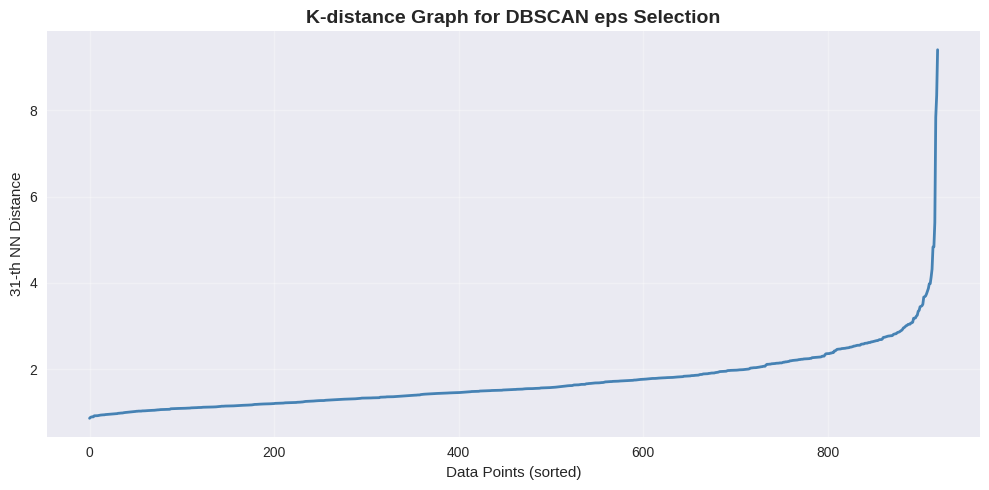

In [38]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# ========================================
# DBSCAN PARAMETER SELECTION (K-Distance Graph)
# ========================================
k = 31
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances, linewidth=2, color='steelblue')
plt.xlabel('Data Points (sorted)')
plt.ylabel(f'{k}-th NN Distance')
plt.title('K-distance Graph for DBSCAN eps Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


DBSCAN (eps=0.7, min_samples=50)
Number of clusters: 0
Noise points: 920 (100.00%)
Not enough clusters for metrics


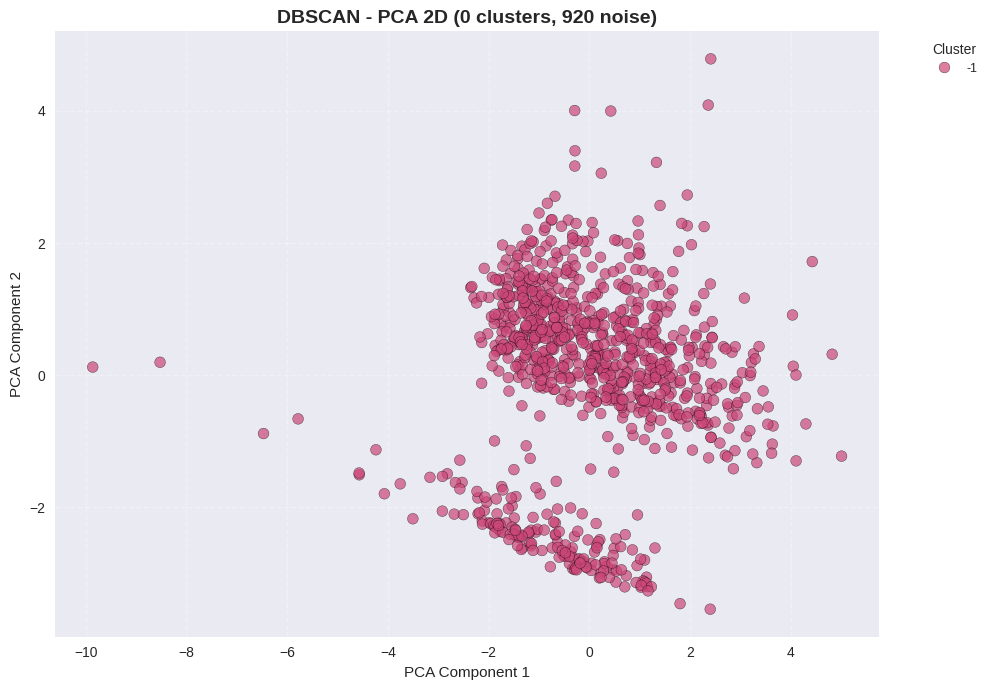

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========================================
# DBSCAN CLUSTERING
# ========================================
eps_value = 0.7
min_samples_value = 50
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, n_jobs=-1)
labels = dbscan.fit_predict(X)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"\nDBSCAN (eps={eps_value}, min_samples={min_samples_value})")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")

# Evaluation Metrics
if n_clusters > 1:
    mask = labels != -1
    if mask.sum() > 0:
        silhouette = silhouette_score(X[mask], labels[mask])
        davies_bouldin = davies_bouldin_score(X[mask], labels[mask])
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    else:
        silhouette = davies_bouldin = np.nan
        print("Not enough non-noise points for metrics")
else:
    silhouette = davies_bouldin = np.nan
    print("Not enough clusters for metrics")

# ========================================
# PCA DIMENSIONALITY REDUCTION
# ========================================
def to_array(X):
    return X.values if hasattr(X, "values") else X

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(to_array(X))
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(to_array(X))

df_viz = pd.DataFrame({
    'pca1': X_pca_2d[:, 0],
    'pca2': X_pca_2d[:, 1],
    'pca3_comp1': X_pca_3d[:, 0],
    'pca3_comp2': X_pca_3d[:, 1],
    'pca3_comp3': X_pca_3d[:, 2],
    'cluster': labels.astype(str)
})

# ========================================
# PCA 2D PLOT
# ========================================
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_viz,
    x='pca1', y='pca2',
    hue='cluster',
    palette='plasma',
    s=60, alpha=0.7,
    edgecolor='k', linewidth=0.3
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
title = f'DBSCAN - PCA 2D ({n_clusters} clusters, {n_noise} noise)'
if not np.isnan(silhouette):
    title += f'\nSilhouette: {silhouette:.4f}'
plt.title(title, fontsize=14, fontweight='bold')
plt.legend(title='Cluster', fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ========================================
# PCA 3D PLOT
# ========================================
fig = px.scatter_3d(
    df_viz,
    x='pca3_comp1',
    y='pca3_comp2',
    z='pca3_comp3',
    color='cluster',
    title=f'DBSCAN - PCA 3D ({n_clusters} clusters, {n_noise} noise)<br>' +
          (f'Silhouette: {silhouette:.4f} | DBI: {davies_bouldin:.4f}' if not np.isnan(silhouette) else 'Metrics: N/A'),
    color_discrete_sequence=px.colors.qualitative.Bold,
    opacity=0.7
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(
    width=900,
    height=700,
    font=dict(size=11),
    title_font=dict(size=14, family='Arial Black'),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.8)",
        title_text="Cluster<br>(-1 = Noise)"
    )
)
fig.show()

## 10. Clustering dengan Annoy

In [ ]:
!pip install annoy

In [40]:
# ========================================
# ANNOY CLUSTERING
# ========================================
import time
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import euclidean_distances

# Siapkan data untuk Annoy
X = data_cluster.values.astype(np.float32)
n_samples, n_features = X.shape

print(f"Jumlah data: {n_samples}")
print(f"Jumlah fitur: {n_features}")
print(f"Shape data: {X.shape}")

Jumlah data: 920
Jumlah fitur: 8
Shape data: (920, 8)


In [41]:
# Build Annoy Index
n_trees = 10
metric = 'euclidean' # menggunakan euclidean karena data telah di normalisasi dan scaling

print("Building Annoy index...")
print(f"- Trees: {n_trees}")
print(f"- Metric: {metric}")

start_build = time.time()
annoy_index = AnnoyIndex(n_features, metric)

for i in range(n_samples):
    annoy_index.add_item(i, X[i])

annoy_index.build(n_trees)
build_time = time.time() - start_build

print(f"✓ Build selesai dalam {round(build_time, 3)} detik")

Building Annoy index...
- Trees: 10
- Metric: euclidean
✓ Build selesai dalam 0.014 detik


In [42]:
# Test Query: Exact NN vs Annoy
query_idx = np.random.randint(0, n_samples)
query_point = X[query_idx]
n_neighbors = 5

print(f"Query index: {query_idx}")
print(f"Mencari {n_neighbors} tetangga terdekat...\n")

# Exact NN (Brute Force)
start = time.time()
distances = np.linalg.norm(X - query_point, axis=1)
idx_exact = np.argsort(distances)[:n_neighbors]
time_exact = time.time() - start

print("Exact NN")
print(f"Index: {idx_exact}")
print(f"Jarak: {distances[idx_exact]}")
print(f"Waktu: {round(time_exact*1000, 4)} ms\n")

# Annoy NN (Approximate)
start = time.time()
idx_annoy = annoy_index.get_nns_by_item(query_idx, n_neighbors)
time_annoy = time.time() - start
annoy_distances = [annoy_index.get_distance(query_idx, i) for i in idx_annoy]

print("Annoy NN")
print(f"Index: {idx_annoy}")
print(f"Jarak: {annoy_distances}")
print(f"Waktu: {round(time_annoy*1000, 4)} ms\n")

# Perbandingan
print("Perbandingan")
print(f"Speedup: {round(time_exact/time_annoy, 2)}x")
print(f"Akurasi: {len(set(idx_exact) & set(idx_annoy))}/{n_neighbors} sama")

Query index: 84
Mencari 5 tetangga terdekat...

Exact NN
Index: [ 84 430 105 148 462]
Jarak: [0.         0.6573246  0.8560628  0.97478586 1.0019109 ]
Waktu: 2.0645 ms

Annoy NN
Index: [84, 430, 105, 148, 462]
Jarak: [0.0, 0.6573246121406555, 0.8560627698898315, 0.9747858643531799, 1.001910924911499]
Waktu: 0.226 ms

Perbandingan
Speedup: 9.13x
Akurasi: 5/5 sama


In [43]:
# Eksperimen jumlah trees
tree_values = [3, 8, 10, 20, 50]
results = []

print("Eksperimen dengan berbagai jumlah trees...\n")

for n_tree in tree_values:
    ann_idx = AnnoyIndex(n_features, 'euclidean')
    for i in range(n_samples):
        ann_idx.add_item(i, X[i])

    start = time.time()
    ann_idx.build(n_tree)
    build_time = time.time() - start

    start = time.time()
    idx_ann = ann_idx.get_nns_by_item(query_idx, n_neighbors)
    query_time = time.time() - start

    accuracy = len(set(idx_exact) & set(idx_ann)) / n_neighbors * 100

    results.append({
        'Trees': n_tree,
        'Build Time (s)': round(build_time, 4),
        'Query Time (ms)': round(query_time * 1000, 4),
        'Accuracy (%)': round(accuracy, 2)
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

Eksperimen dengan berbagai jumlah trees...

 Trees  Build Time (s)  Query Time (ms)  Accuracy (%)
     3          0.0067           0.0191          80.0
     8          0.0140           0.0327         100.0
    10          0.0190           0.0393         100.0
    20          0.0284           0.0672         100.0
    50          0.0919           0.1791         100.0


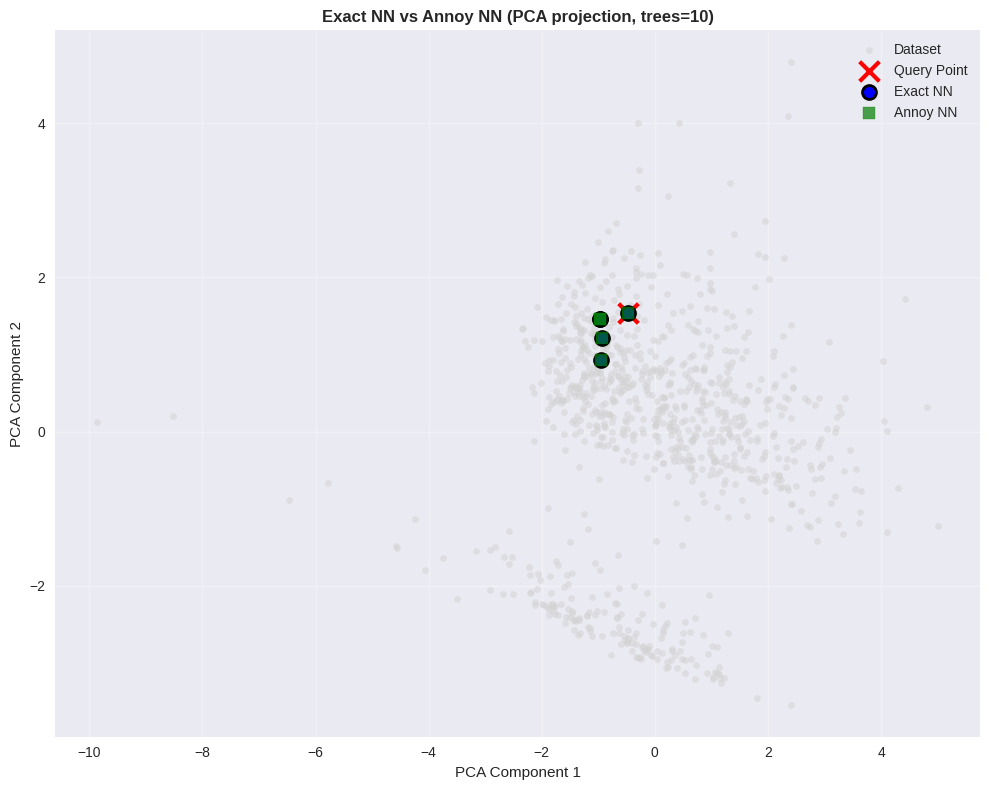

In [44]:
# PCA reduksi ke 2 dimensi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Visualisasi hasil
plt.figure(figsize=(10, 8))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=20, alpha=0.5, label='Dataset')
plt.scatter(pca.transform([query_point])[0, 0],
            pca.transform([query_point])[0, 1],
            c='red', marker='x', s=200, linewidths=3, label='Query Point')
plt.scatter(X_pca[idx_exact, 0], X_pca[idx_exact, 1],
            c='blue', s=100, marker='o', label='Exact NN',
            edgecolors='black', linewidths=2)
plt.scatter(X_pca[idx_annoy, 0], X_pca[idx_annoy, 1],
            c='green', s=80, marker='s', label='Annoy NN', alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Exact NN vs Annoy NN (PCA projection, trees={n_trees})', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Cari nearest neighbors untuk semua data
k = 5
print(f"Mencari {k} nearest neighbors untuk semua data...")

start = time.time()
all_neighbors = []
for i in range(n_samples):
    neighbors = annoy_index.get_nns_by_item(i, k)
    all_neighbors.append(neighbors)
time_all = time.time() - start

print(f"✓ Selesai dalam {round(time_all, 3)} detik")
print(f"Rata-rata {round(time_all/n_samples*1000, 4)} ms per query")

# Contoh hasil untuk 5 data pertama
print("\nContoh neighbors untuk 5 data pertama:")
for i in range(min(5, n_samples)):
    print(f"Data {i}: {all_neighbors[i][:5]}...")

Mencari 5 nearest neighbors untuk semua data...
✓ Selesai dalam 0.016 detik
Rata-rata 0.0178 ms per query

Contoh neighbors untuk 5 data pertama:
Data 0: [0, 243, 786, 189, 43]...
Data 1: [1, 815, 821, 580, 908]...
Data 2: [2, 154, 119, 838, 837]...
Data 3: [3, 211, 495, 212, 69]...
Data 4: [4, 61, 389, 388, 125]...


In [46]:
# Perbandingan berbagai distance metrics
metrics = ['euclidean', 'angular', 'manhattan']
metric_results = []

print("Membandingkan berbagai distance metrics...\n")

for metric in metrics:
    ann = AnnoyIndex(n_features, metric)
    for i in range(n_samples):
        ann.add_item(i, X[i])
    ann.build(10)

    start = time.time()
    idx = ann.get_nns_by_item(query_idx, n_neighbors)
    query_time = time.time() - start

    metric_results.append({
        'Metric': metric,
        'Query Time (ms)': round(query_time * 1000, 4),
        'Result': idx
    })

    print(f"{metric:10s}: {round(query_time*1000, 4)} ms | {idx}")

print("\n✓ Perbandingan selesai")

Membandingkan berbagai distance metrics...

euclidean : 0.0377 ms | [84, 430, 105, 148, 462]
angular   : 0.0341 ms | [84, 430, 105, 906, 259]
manhattan : 0.0312 ms | [84, 430, 105, 438, 462]

✓ Perbandingan selesai
